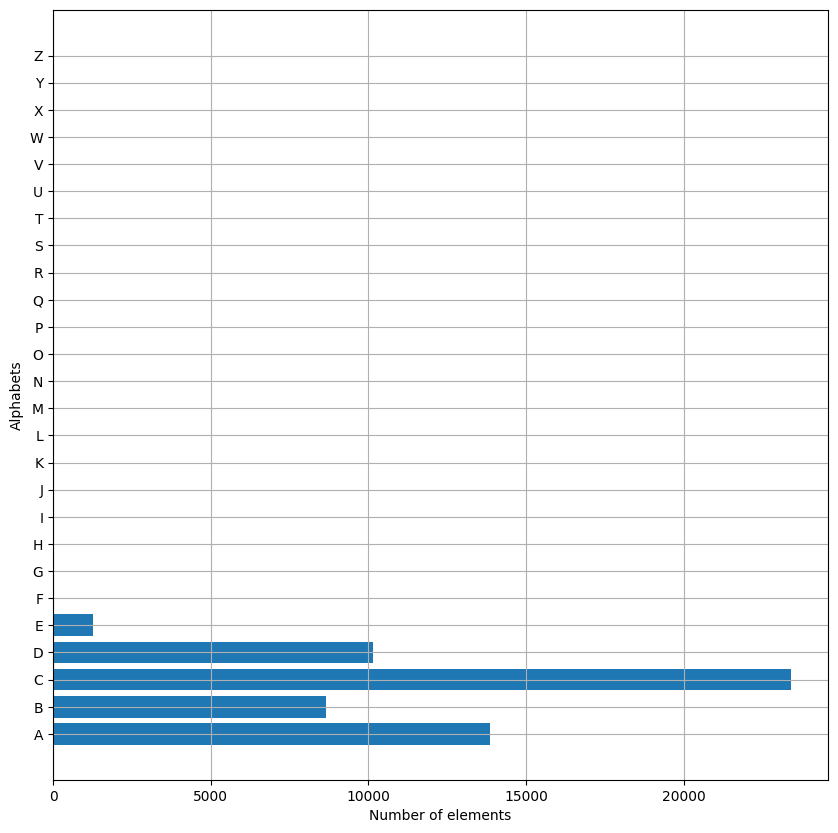

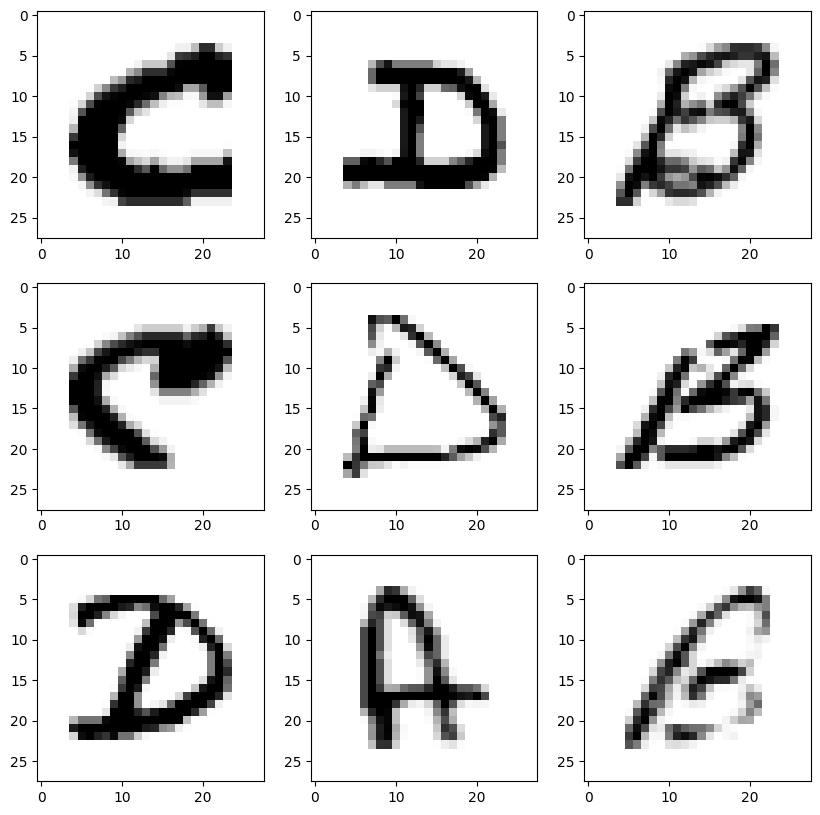

Epoch 1/10
1434/1434 [==============================] - 64s 43ms/step - loss: nan - accuracy: 0.7489 - val_loss: nan - val_accuracy: 0.2434 - lr: 0.0010
Epoch 2/10
1434/1434 [==============================] - 60s 42ms/step - loss: nan - accuracy: 0.2415 - val_loss: nan - val_accuracy: 0.2434 - lr: 2.0000e-04
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 148ms/step


DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


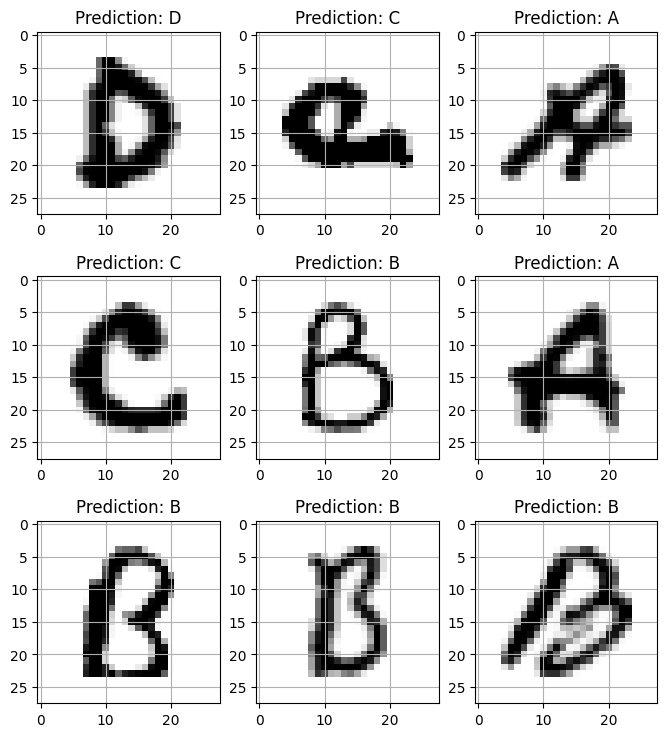

In [8]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv(r"/content/A_Z Handwritten Data.csv").astype('float32')

# Split data into features and labels
X = data.drop('0', axis=1)
y = data['0']

# Split data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
train_x = np.reshape(train_x.values, (train_x.shape[0], 28, 28))
test_x = np.reshape(test_x.values, (test_x.shape[0], 28, 28))

# Dictionary for mapping labels to characters
word_dict = {i: chr(65 + i) for i in range(26)}

# Plotting the number of each alphabet in the dataset
train_yint = np.intp(y)
count = np.zeros(26, dtype='int')
for i in train_yint:
    count[i] += 1

alphabets = list(word_dict.values())

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.barh(alphabets, count)
plt.xlabel("Number of elements")
plt.ylabel("Alphabets")
plt.grid()
plt.show()

# Shuffling and displaying some training images
shuff = shuffle(train_x[:100])

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
axes = ax.flatten()
for i in range(9):
    axes[i].imshow(np.reshape(shuff[i], (28, 28)), cmap="Greys")
plt.show()

# Reshape data for the model
train_X = train_x.reshape(train_x.shape[0], 28, 28, 1)
test_X = test_x.reshape(test_x.shape[0], 28, 28, 1)

# Convert labels to one-hot encoding
train_yOHE = to_categorical(train_y, num_classes=26, dtype='int')
test_yOHE = to_categorical(test_y, num_classes=26, dtype='int')

# Build the CNN model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(26, activation="softmax"))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Train the model
history = model.fit(train_X, train_yOHE, epochs=10, callbacks=[reduce_lr, early_stop], validation_data=(test_X, test_yOHE))

# Display model summary
model.summary()

# Save the model
model.save(r'/content/model_hand.h5')

# Display training and validation metrics
print("The validation accuracy is:", history.history['val_accuracy'])
print("The training accuracy is:", history.history['accuracy'])
print("The validation loss is:", history.history['val_loss'])
print("The training loss is:", history.history['loss'])

# Display some test images and their predicted labels
fig, axes = plt.subplots(3, 3, figsize=(8, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    img = np.reshape(test_X[i], (28, 28))
    ax.imshow(img, cmap="Greys")
    pred = word_dict[np.argmax(test_yOHE[i])]
    ax.set_title("Prediction: " + pred)
    ax.grid()

# Prediction on an external image
img = cv2.imread(r'/content/character-grayscale-images.webp')
img_copy = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400, 440))

img_copy = cv2.GaussianBlur(img_copy, (7, 7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)

img_final = cv2.resize(img_thresh, (28, 28))
img_final = np.reshape(img_final, (1, 28, 28, 1))

img_pred = word_dict[np.argmax(model.predict(img_final))]

cv2.putText(img, "Dataflair _ _ _ ", (20, 25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color=(0, 0, 230))
cv2.putText(img, "Prediction: " + img_pred, (20, 410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color=(255, 0, 30))
cv2.imshow('Dataflair handwritten character recognition _ _ _ ', img)

while True:
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()
